In [20]:
# Step 1: Setup Environment
# Install necessary libraries
!pip install torch torchvision opencv-python opencv-contrib-python
!pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1+cu116 --index-url https://download.pytorch.org/whl/cu116
!pip install dgl==1.1.3+cu121 -f https://data.dgl.ai/wheels/cu121/repo.html
!pip install timm==0.4.12

Looking in indexes: https://download.pytorch.org/whl/cu116
Looking in links: https://data.dgl.ai/wheels/cu121/repo.html


In [3]:
# Clone the CAST repository
!git clone https://github.com/twke18/CAST.git


fatal: destination path 'CAST' already exists and is not an empty directory.


In [ ]:
import yaml

# Load the YAML file
with open('/content/CAST/environment.yaml', 'r') as file:
    env_data = yaml.safe_load(file)

# Extract dependencies
dependencies = env_data.get('dependencies', [])

# Install pip dependencies
for dep in dependencies:
    if isinstance(dep, str):  # If it's a pip package
        !pip install {dep}
    elif isinstance(dep, dict) and 'pip' in dep:  # If it's a pip section
        for pip_dep in dep['pip']:
            !pip install {pip_dep}


ERROR: Invalid requirement: 'python=3.9': Expected end or semicolon (after name and no valid version specifier)
    python=3.9
          ^
Hint: = is not a valid operator. Did you mean == ?
ERROR: Could not find a version that satisfies the requirement pytorch==1.13.1 (from versions: 0.1.2, 1.0.2)
ERROR: No matching distribution found for pytorch==1.13.1
  Using cached PyYAML-5.3.tar.gz (268 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
Using cached torch-2.5.1-cp310-cp310-m

  Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl.metadata (24 kB)
Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl (887.5 MB)
ERROR: Operation cancelled by user


In [5]:
%cd /content/CAST

/content/CAST


In [5]:
# Step 2: Prepare Pascal VOC Dataset
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [6]:
import os

DATAROOT = '/content/VOCdevkit'
VOC2012_DIR = os.path.join(DATAROOT, 'VOC2012')

os.makedirs(VOC2012_DIR, exist_ok=True)

# Download and extract VOC 2012 dataset
!wget -O VOCtrainval_11-May-2012.tar 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar'
!tar -xvf VOCtrainval_11-May-2012.tar -C /content/CAST/data

dir1_path = "/content/CAST/data/VOCdevkit"
dir2_path = os.path.join(dir1_path, "sbd")
dir3_path = os.path.join(dir2_path, "dataset")

os.makedirs(dir2_path, exist_ok=True)
os.makedirs(dir3_path, exist_ok=True)


Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC

In [7]:
!unzip /content/segcls.zip -d /content/CAST/data/VOCdevkit/VOC2012
!unzip /content/hed.zip -d /content/CAST/data/VOCdevkit/VOC2012
!unzip /content/sbd_clsimg.zip -d /content/CAST/data/VOCdevkit/sbd/dataset

Archive:  /content/segcls.zip
replace /content/CAST/data/VOCdevkit/VOC2012/segcls/2011_000618.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/hed.zip
replace /content/CAST/data/VOCdevkit/VOC2012/hed/2011_000618.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/sbd_clsimg.zip
replace /content/CAST/data/VOCdevkit/sbd/dataset/clsimg/2011_000618.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
# Import necessary libraries
import torch
import cv2
import os
from cast_models.cast_seg import cast_small

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [7]:
# Define dataset paths
VOCdevkit_path = '/content/VOCdevkit/'
JPEGImages_path = os.path.join(VOCdevkit_path, 'VOC2012/JPEGImages/')
segcls_path = os.path.join(VOCdevkit_path, 'VOC2012/segcls/')
sbd_path = os.path.join(VOCdevkit_path, 'sbd/dataset/clsimg/')

In [8]:
# Download model checkpoints
!wget -O checkpoint_0149.pth.tar https://huggingface.co/twke/CAST/resolve/main/snapshots/moco/coco/cast_small/checkpoint_0149.pth.tar
# Download fine-tuned checkpoint
!wget -O checkpoint_0399.pth.tar https://huggingface.co/twke/CAST/resolve/main/snapshots/moco/coco/cast_small/checkpoint_0399.pth.tar

--2024-12-27 14:43:30--  https://huggingface.co/twke/CAST/resolve/main/snapshots/moco/coco/cast_small/checkpoint_0149.pth.tar
Resolving huggingface.co (huggingface.co)... 18.239.50.49, 18.239.50.80, 18.239.50.103, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.49|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/07/97/07974173035d95e4743a789a61e1809d83f2e970a7a22886429996b77098f621/a592f7a4067d34cec3b77283892818e2bd1199b043daa4d5b570c43da97e170c?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27checkpoint_0149.pth.tar%3B+filename%3D%22checkpoint_0149.pth.tar%22%3B&response-content-type=application%2Fx-tar&Expires=1735569810&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNTU2OTgxMH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzA3Lzk3LzA3OTc0MTczMDM1ZDk1ZTQ3NDNhNzg5YTYxZTE4MDlkODNmMmU5NzBhN2EyMjg4NjQyOTk5NmI3NzA5OGY2MjEvYTU5MmY3YTQwNjdkMzRjZW

In [9]:
import random
import numpy as np
import torch

# Set random seeds
seed = 10  # Choose any desired seed value
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using CUDA

# Enable deterministic CUDA operations (optional, might impact performance)
torch.backends.cudnn.deterministic = True
# ... (Rest of your model loading code)
# Initialize the CAST model
model = cast_small()
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Load pre-trained weights (adjust the path as needed)
# Load the checkpoint
checkpoint = torch.load('/content/CAST/checkpoint_0399.pth.tar')
# Extract the state_dict from the checkpoint
state_dict = checkpoint['state_dict']

# Update keys in the state_dict to remove the module prefix (if present)
# This is necessary if the checkpoint was saved using DataParallel
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

# Load the state_dict into the model
model.load_state_dict(state_dict, strict=False)
# Move model to the appropriate device (GPU or CPU)
model = model.to(device)
model.eval()


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Using device: cuda


<ipython-input-9-f29abb6506ab>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/CAST/checkpoint_0399.pth.tar')


CAST(
  (patch_embed): ConvStem(
    (proj): Sequential(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    )
    (norm): Identity()
  )


In [10]:
from IPython import get_ipython
from IPython.display import display
min_segments=768
def prepare_superpixels(image_path, min_segments=min_segments):  # min_segments is used as the target
    image = cv2.imread(image_path)
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    n_segments = 1000  # Start with a lower value
    while True:
        seeds = cv2.ximgproc.createSuperpixelSEEDS(
            image_lab.shape[1],
            image_lab.shape[0],
            image_lab.shape[2],
            num_superpixels=n_segments,  # Use n_segments here
            num_levels=1,
            prior=2,
            histogram_bins=15,
            double_step=False,
        )
        seeds.iterate(image_lab, num_iterations=20)
        segments = seeds.getLabels()
        num_superpixels = segments.max() + 1

        if num_superpixels >= min_segments:  # Check against min_segments
            break
        else:
            n_segments += 50  # Increment n_segments
    return torch.LongTensor(segments)


In [11]:
def run_prediction(image_path, min_segments=min_segments, perturb_superpixels=False):
     # Adjust shape and data type    # Prepare image
    image = cv2.imread(image_path)

    # Check if image was loaded successfully
    if image is None:
        raise ValueError(f"Error: Could not load image from {image_path}. Please check the file path and ensure the image exists.")

    # Get image dimensions
    image_height, image_width, image_channels = image.shape

    # Initialize tensors with correct shapes
    image_tensor = torch.zeros((1, image_channels, image_height, image_width), dtype=torch.float32, device=device)
    superpixels = torch.zeros((1, image_height, image_width), dtype=torch.int64, device=device)

    image_tensor = torch.as_tensor(image).unsqueeze(0).permute(0, 3, 1, 2).float() / 255.0

    # Move image_tensor to the same device as the model
    image_tensor = image_tensor.to(device)
    # Reset model state (if applicable):
    if hasattr(model, 'reset_hidden_state'):
        model.reset_hidden_state()
    # Prepare superpixels
    superpixels = prepare_superpixels(image_path, min_segments=min_segments) # Passing min_segments
    superpixels = superpixels.unsqueeze(0)
    if perturb_superpixels:
        # Add random noise to the superpixel values
        noise = torch.randint(0, 5000, superpixels.shape, device=device)  # Adjust noise range if needed
        superpixels = (superpixels) % (superpixels.max() + 1)  # Keep within valid range
    # Move superpixels to the same device as the model
    superpixels = superpixels.to(device)
    print(f"Image tensor shape: {image_tensor.shape}")
    print(f"Superpixels shape: {superpixels.shape}")
    # visualize_feature_maps(model, image_tensor, superpixels)
    # --- Diagnostic print statement ---


    # Run model
    output = model(image_tensor, superpixels)
    print(f"Output shape: {output.shape}")
    # Get predicted segmentation map
    predicted_segments = torch.argmax(output, dim=-1).squeeze(0)
    print(f"Predicted segments shape: {predicted_segments.shape}")

    return output


Image tensor shape: torch.Size([1, 3, 375, 500])
Superpixels shape: torch.Size([1, 375, 500])
Output shape: torch.Size([1, 910, 1000])
Predicted segments shape: torch.Size([910])


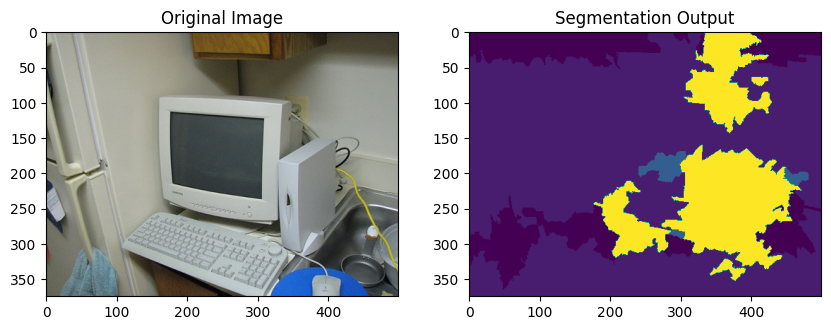

In [12]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
def visualize_prediction(image_path, output, superpixels):
    # # Check if output needs to be reduced in dimensions
    # if output.shape[-1] != superpixels.max() + 1:
    #     output = F.interpolate(output.permute(0, 2, 1), size=(superpixels.max() + 1,), mode='linear')
    #     output = output.permute(0, 2, 1)

    # Get the predicted segmentation map by assigning the highest score feature
    predicted_segments = torch.argmax(output, dim=-1).squeeze(0)

    # Convert the superpixels back to the image dimensions
    num_superpixels = superpixels.max().item() + 1
    segmented_image = predicted_segments[superpixels.squeeze(0)]

    segmented_image = segmented_image.cpu().numpy()


    # Load the original image
    image = cv2.imread(image_path)

    # Display the original image and the segmented image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image, cmap='viridis')
    plt.title('Segmentation Output')

    plt.show()

# Example usage
image_path = "/content/CAST/data/VOCdevkit/VOC2012/JPEGImages/2007_000039.jpg"
output = run_prediction(image_path)
visualize_prediction(image_path, output, prepare_superpixels(image_path))



Image tensor shape: torch.Size([1, 3, 366, 500])
Superpixels shape: torch.Size([1, 366, 500])
Output shape: torch.Size([1, 910, 1000])
Predicted segments shape: torch.Size([910])


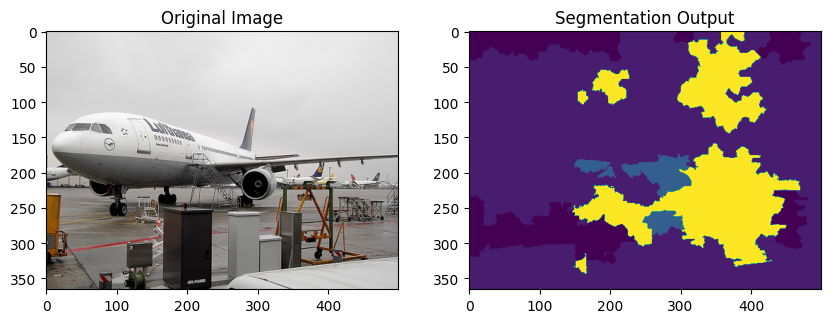

In [13]:
image_path2 = "/content/CAST/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"
output = run_prediction(image_path2)
visualize_prediction(image_path2, output, prepare_superpixels(image_path2))


In [14]:
# !pip install scikit-image
# import cv2
# import torch
# import matplotlib.pyplot as plt
# from skimage.segmentation import slic
# from skimage.util import img_as_float

# # ... (Your previous code: model initialization, imports, etc.)

# def prepare_superpixels_skimage(image_path, min_segments=384):
#     """Generates superpixels using scikit-image's SLIC algorithm."""
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
#     image_float = img_as_float(image)  # skimage works with float images

#     # Generate superpixels
#     segments = slic(
#         image_float,
#         n_segments=min_segments,  # Directly control the number of segments
#         compactness=20,  # Adjust compactness as needed
#         sigma=1,  # Adjust sigma for smoothing
#         start_label=0,
#     )

#     return torch.LongTensor(segments)

# def run_prediction(image_path, min_segments=384, perturb_superpixels=False):
#     """Runs prediction using the CAST model."""
#     # Prepare image
#     image = cv2.imread(image_path)
#     if image is None:
#         raise ValueError(f"Error: Could not load image from {image_path}. Please check the file path and ensure the image exists.")

#     # Preprocess the image  (This part was missing)
#     image_tensor = torch.as_tensor(image).unsqueeze(0).permute(0, 3, 1, 2).float() / 255.0
#     image_tensor = image_tensor.to(device)

#     # Prepare superpixels using skimage
#     superpixels = prepare_superpixels_skimage(image_path, min_segments=min_segments)
#     superpixels = superpixels.unsqueeze(0)  # Add batch dimension
#     superpixels = superpixels.to(device)

#     # Print shapes for debugging
#     print(f"Input Image Shape: {image_tensor.shape}")
#     print(f"Superpixel Image Shape: {superpixels.shape}")

#     # Run the model
#     with torch.no_grad():
#         output = model(image_tensor, superpixels)

#     print(f"Output shape: {output.shape}")

#     return output, superpixels  # Return superpixels for visualization

# def visualize_prediction(image_path, output, superpixels):
#     """Visualizes the segmentation output."""
#     # Check if output needs to be reduced in dimensions and adjust using interpolation
#     if output.shape[-1] != superpixels.max() + 1:
#         output = F.interpolate(output.permute(0, 2, 1), size=(superpixels.max() + 1,), mode='linear')
#         output = output.permute(0, 2, 1)

#     # Get the predicted segmentation map
#     predicted_segments = torch.argmax(output, dim=-1).squeeze(0)

#     # Convert the superpixels back to the image dimensions
#     segmented_image = torch.zeros_like(superpixels.squeeze(0))
#     for i in range(predicted_segments.size(0)):
#         segmented_image[superpixels.squeeze(0) == i] = predicted_segments[i]

#     segmented_image = segmented_image.cpu().numpy()

#     # Load the original image
#     image = cv2.imread(image_path)

#     # Display the original image and the segmented image
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert to RGB for display
#     plt.title('Original Image')

#     plt.subplot(1, 2, 2)
#     plt.imshow(segmented_image, cmap='viridis')
#     plt.title('Segmentation Output')

#     plt.show()

# # Example usage:
# image_path = "/content/CAST/data/VOCdevkit/VOC2012/JPEGImages/2007_000039.jpg"
# output, superpixels = run_prediction(image_path)  # Get superpixels for visualization
# visualize_prediction(image_path, output, superpixels)

In [15]:
!pip install torchmetrics

In [16]:
import torch
from torchmetrics import JaccardIndex, F1Score
import numpy as np

In [17]:
def calculate_miou(predictions, targets, num_classes):
    """Calculates the mean Intersection over Union (mIoU)."""
    iou = JaccardIndex(task="multiclass", num_classes=num_classes)
    miou = iou(predictions, targets)  # Calculate IoU for each class
    return miou.item()  # Return the mean IoU

def calculate_boundary_f_score(predictions, targets, num_classes):
    """
    Calculates the boundary F-score using morphological operations
    to find boundaries and then comparing the predicted and true boundaries.
    """
    # Assuming predictions and targets are NumPy arrays...
    predictions = predictions.astype(np.uint8)
    targets = targets.astype(np.uint8)

    # Calculate boundaries using morphological operations (e.g., dilation and erosion)
    predicted_boundaries = find_boundaries(predictions)  # Implement 'find_boundaries' function
    target_boundaries = find_boundaries(targets)  # Implement 'find_boundaries' function

    # Calculate F-score for boundary pixels
    f1 = F1Score(task="binary")  # Use binary F1 for boundary evaluation
    boundary_f_score = f1(predicted_boundaries, target_boundaries)

    return boundary_f_score.item()


def find_boundaries(segmentation_mask):
    """
    Finds the boundaries of objects in a segmentation mask using morphological operations.
    """
    # ... (Implementation using OpenCV or Scikit-image) ...
    # Example using OpenCV:
    import cv2
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(segmentation_mask, kernel, iterations=1)
    eroded = cv2.erode(segmentation_mask, kernel, iterations=1)
    boundaries = dilated - eroded
    return boundaries

In [18]:
def run_prediction(image_path, min_segments=min_segments, perturb_superpixels=False):
     # Adjust shape and data type    # Prepare image
    image = cv2.imread(image_path)

    # Check if image was loaded successfully
    if image is None:
        raise ValueError(f"Error: Could not load image from {image_path}. Please check the file path and ensure the image exists.")

    # Get image dimensions
    image_height, image_width, image_channels = image.shape

    # Initialize tensors with correct shapes
    image_tensor = torch.zeros((1, image_channels, image_height, image_width), dtype=torch.float32, device=device)
    superpixels = torch.zeros((1, image_height, image_width), dtype=torch.int64, device=device)

    image_tensor = torch.as_tensor(image).unsqueeze(0).permute(0, 3, 1, 2).float() / 255.0

    # Move image_tensor to the same device as the model
    image_tensor = image_tensor.to(device)
    # Reset model state (if applicable):
    if hasattr(model, 'reset_hidden_state'):
        model.reset_hidden_state()
    # Prepare superpixels
    superpixels = prepare_superpixels(image_path, min_segments=min_segments) # Passing min_segments
    superpixels = superpixels.unsqueeze(0)
    if perturb_superpixels:
        # Add random noise to the superpixel values
        noise = torch.randint(0, 5000, superpixels.shape, device=device)  # Adjust noise range if needed
        superpixels = (superpixels) % (superpixels.max() + 1)  # Keep within valid range
    # Move superpixels to the same device as the model
    superpixels = superpixels.to(device)
    print(f"Image tensor shape: {image_tensor.shape}")
    print(f"Superpixels shape: {superpixels.shape}")
    # visualize_feature_maps(model, image_tensor, superpixels)
    # --- Diagnostic print statement ---


    # Run model
    output = model(image_tensor, superpixels)
    print(f"Output shape: {output.shape}")
    # Get predicted segmentation map
    predicted_segments = torch.argmax(output, dim=-1).squeeze(0)
    print(f"Predicted segments shape: {predicted_segments.shape}")

    return predicted_segments




In [21]:
import os
import cv2

def load_ground_truth_labels(image_path, voc_root="/content/VOCdevkit/VOC2012"):
    """Loads the ground truth segmentation mask for an image, handling potential errors."""
    image_filename = os.path.basename(image_path)
    image_name, _ = os.path.splitext(image_filename)
    segmentation_path = os.path.join(voc_root, "SegmentationClass", image_name + ".png")

    try:
        segmentation_mask = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)

        if segmentation_mask is None:  # Check if image loaded successfully
            raise IOError(f"Could not load ground truth mask at: {segmentation_path}")

        return segmentation_mask

    except (IOError, Exception) as e:
        print(f"Error loading ground truth for {image_path}: {e}")
        return None  # Return None if an error occurred

In [ ]:
import os
import glob
import cv2
import torch
from torchmetrics import JaccardIndex, F1Score
import numpy as np

# ... (Your existing functions: load_ground_truth_labels, calculate_miou, calculate_boundary_f_score, find_boundaries, run_prediction) ...
def evaluate_on_dataset(image_folder, voc_root="/content/VOCdevkit/VOC2012", num_classes=21):
    """
    Evaluates the model on a set of images, skipping those with missing ground truth.
    """
    image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))
    all_miou_scores = []
    all_boundary_f_scores = []

    for image_path in image_paths:
        # Load ground truth labels
        targets = load_ground_truth_labels(image_path, voc_root=voc_root)

        # Skip if ground truth is missing
        if targets is None:
            print(f"Skipping image {image_path} due to missing ground truth.")
            continue

        try:
            # Get predictions
            predictions = run_prediction(image_path)
            predictions = predictions.cpu().numpy()
            targets = targets.astype(np.int64)  # Convert targets to int64

            # Calculate mIoU and boundary F-score for the current image
            miou = calculate_miou(predictions, targets, num_classes=num_classes)
            boundary_f_score = calculate_boundary_f_score(predictions, targets, num_classes=num_classes)

            all_miou_scores.append(miou)
            all_boundary_f_scores.append(boundary_f_score)

        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            continue  # Skip to the next image if another error occurs

    # ... (rest of the function remains the same)
    # Calculate average scores across all images
    avg_miou = np.mean(all_miou_scores) if all_miou_scores else 0
    avg_boundary_f_score = np.mean(all_boundary_f_scores) if all_boundary_f_scores else 0

    print(f"Average mIoU: {avg_miou}")
    print(f"Average Boundary F-score: {avg_boundary_f_score}")

# Example usage:
image_folder = "/content/CAST/data/VOCdevkit/VOC2012/JPEGImages"
evaluate_on_dataset(image_folder)

Streaming output truncated to the last 5000 lines.
Error loading ground truth for /content/CAST/data/VOCdevkit/VOC2012/JPEGImages/2010_004466.jpg: Could not load ground truth mask at: /content/VOCdevkit/VOC2012/SegmentationClass/2010_004466.png
Skipping image /content/CAST/data/VOCdevkit/VOC2012/JPEGImages/2010_004466.jpg due to missing ground truth.
Error loading ground truth for /content/CAST/data/VOCdevkit/VOC2012/JPEGImages/2011_000317.jpg: Could not load ground truth mask at: /content/VOCdevkit/VOC2012/SegmentationClass/2011_000317.png
Skipping image /content/CAST/data/VOCdevkit/VOC2012/JPEGImages/2011_000317.jpg due to missing ground truth.
Error loading ground truth for /content/CAST/data/VOCdevkit/VOC2012/JPEGImages/2010_005519.jpg: Could not load ground truth mask at: /content/VOCdevkit/VOC2012/SegmentationClass/2010_005519.png
Skipping image /content/CAST/data/VOCdevkit/VOC2012/JPEGImages/2010_005519.jpg due to missing ground truth.
Error loading ground truth for /content/CAS